# Optimal lookback momentum strategy

This is code for finding the optimal momentum lookback for a selection of country ETFs. The strategy default is with 3 long legs and no short legs. First, we load all the necessary packages.

In [1]:
import yfinance as yf #for pulling the data
import numpy as np #for calculations and formatting
from numpy.linalg import inv #for calculations and formatting
import pandas as pd #for calculations and formatting
import matplotlib.pyplot as plt #for graphs
import os #for saving the plots and data files
from tabulate import tabulate #for creating tables
from scipy.stats import skew, kurtosis #for statistics
import seaborn as sns #for plot colors

## Parameter adjustment
The default for the strategy is set for the below parameters, however the user can adjust them however they wish - while keeping in mind the limits listed above each parameter.

### Time frame
First you can choose the start and end date of your strategy.

In [2]:
# The time series needs to be at least 24 months long in order to work
# we reccommend taking a series of at least 5 years to make the results representable
start_date = '2014-01-01'
end_date = '2024-09-20'

### Investmen universe

Next you can choose which countries to include in the investment universe - below is the list with tickers

1. MSCI USA
ETF Name: iShares MSCI USA ETF
Yahoo Ticker: EUSA
2. MSCI China
ETF Name: iShares MSCI China ETF
Yahoo Ticker: MCHI
3. MSCI Japan
ETF Name: iShares MSCI Japan ETF
Yahoo Ticker: EWJ
4. MSCI India
ETF Name: iShares MSCI India ETF
Yahoo Ticker: INDA
5. MSCI Brazil
ETF Name: iShares MSCI Brazil ETF
Yahoo Ticker: EWZ
6. MSCI Canada
ETF Name: iShares MSCI Canada ETF
Yahoo Ticker: EWC
7. MSCI Mexico
ETF Name: iShares MSCI Mexico ETF
Yahoo Ticker: EWW
8. MSCI South Korea
ETF Name: iShares MSCI South Korea ETF
Yahoo Ticker: EWY
9. MSCI Germany
ETF Name: iShares MSCI Germany ETF
Yahoo Ticker: EWG
10. MSCI United Kingdom
ETF Name: iShares MSCI United Kingdom ETF
Yahoo Ticker: EWU
11. MSCI Australia
ETF Name: iShares MSCI Australia ETF
Yahoo Ticker: EWA
12. MSCI Switzerland
ETF Name: iShares MSCI Switzerland ETF
Yahoo Ticker: EWL
13. MSCI Hong Kong
ETF Name: iShares MSCI Hong Kong ETF
Yahoo Ticker: EWH
14. MSCI Singapore
ETF Name: iShares MSCI Singapore ETF
Yahoo Ticker: EWS
15. MSCI Taiwan
ETF Name: iShares MSCI Taiwan ETF
Yahoo Ticker: EWT
16. MSCI Italy
ETF Name: iShares MSCI Italy ETF
Yahoo Ticker: EWI
17. MSCI Spain
ETF Name: iShares MSCI Spain ETF
Yahoo Ticker: EWP

In [3]:
# Here you can choose the countries in scope 
#If you remove certain tickers you need to remove corresponding country names in new_col_names_list  
country_list = ['EUSA', 'MCHI', 'EWJ', 'INDA', 'EWZ', 'EWC', 'EWW', 'EWY','EWG', 'EWU', 'EWA', 'EWL', 'EWH', 
                'EWS', 'EWT', 'EWI', 'EWP' ]
new_col_names_list = ['USA', 'China', 'Japan', 'India', 'Brazil', 'Canada', 'Mexico', 'South Korea',
                    'Germany', 'UK', 'Australia', 'Switzerland', 'Hong Kong', 'Singapore', 
                    'Taiwan', 'Italy', 'Spain']

### Risk free rate measure
Next you can specify what you wish to use as a risk free measure - we use the US 3-Month Treasury rate

In [4]:
#risk free
Rf_list = ['^IRX']

### Lookbacks
Here you can specify what length of lookbacks you wish to investingate. We search for the optimal lookback withing 1-24 months

In [5]:
max_lookback = 24  # Maximum lookback period
#for visualisation - How many top&bottom strategies do you want to show in the graphs?
#x can be between 1 and 3
x=2 #shows graphs of only top 2 and bottom 2 performing lookback strategies

### Short and long lags
Choose how many country ETFs you will go long and how many you will go short. Keep in mind that you should choose the number that is at least smaller than the number of all ETFs you chose in the"Investment universe" step divided by 2

In [6]:
nLong = 3 #number of ETFs the strategy goes long (buys)
nShort = 0 #number of ETFs the strategy shorts (sells)

### Transaction costs

To make the strategy more realistic we include returns including the transaction costs. Here you can set that value.

In [7]:
tCost = 0.001

## ETF price data 

Here we download ETF price data from Yahoo finance and save it as raw data. Then we process it for further use in the backtest. The processed data is also saved separately. In the end we also show the summary statistics of the ETF price data for each country ETF.

In [8]:
#download ETF price data from Yahoo
ETFPrices = yf.download(country_list, 
                   start=start_date, 
                   end=end_date)
ETFPrices = pd.DataFrame(ETFPrices)

#save the raw data to data/raw file
# Get the current working directory
current_directory = os.getcwd()
# Directory path
directory_add_on = './data/raw/ETFPrices.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
ETFPrices.to_csv(full_directory_path, index=False)


[*********************100%***********************]  17 of 17 completed


In [9]:
# Keep only 'Adjusted Close' columns
ETFPrices = ETFPrices[[ 'Adj Close']]
ETFPrices = ETFPrices.rename(columns={'Adj Close': 'Price'}) #rename it for clearer understanding

ETFPrices.columns = new_col_names_list#only for the purposes of creating a nice looking table for descriptive statistics
#Date is downloaded as an index and we want to add it as a column
# Step 1: Access the date index
date_index = ETFPrices.index.tolist()  # Convert the index to a list
# Step 2: Add the date as a column (if necessary)
ETFPrices['Date'] = ETFPrices.index  # Add the date index as a new column

#saving the processed version of the data under data/processed
# Get the current working directory
current_directory = os.getcwd()
# Directory path
directory_add_on = './data/processed/ETFPrices_processed.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
ETFPrices.to_csv(full_directory_path, index=False)

In [10]:
#summary statistics for price data
# Generate summary statistics using .describe()
summary_stats = ETFPrices.describe().transpose()

# Format the summary statistics table 
summary_stats['Mean'] = summary_stats['mean']
summary_stats['Std'] = summary_stats['std']
summary_stats['Min'] = summary_stats['min']
summary_stats['25%'] = summary_stats['25%']
summary_stats['50%'] = summary_stats['50%']
summary_stats['75%'] = summary_stats['75%']
summary_stats['Max'] = summary_stats['max']

# Select and order the columns for a clean output
summary_stats = summary_stats[['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']]

# Display the table using tabulate 
print(tabulate(summary_stats, headers='keys', tablefmt='pipe', floatfmt=".4f"))

|             |    Mean |     Std |     Min |     25% |     50% |     75% |     Max |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| USA         | 56.7352 | 17.6018 | 31.1307 | 39.8472 | 52.5221 | 73.6415 | 95.0078 |
| China       | 18.0947 |  3.3723 | 10.7066 | 15.6059 | 17.2929 | 21.2886 | 26.8200 |
| Japan       | 27.2604 |  5.7840 | 15.5576 | 22.9199 | 25.1957 | 33.0867 | 41.1500 |
| India       | 25.0526 |  3.4533 | 15.8377 | 22.5065 | 24.6239 | 27.3886 | 33.0900 |
| Brazil      | 18.5063 |  2.7380 | 12.8342 | 16.0820 | 18.7257 | 20.5221 | 25.0314 |
| Canada      | 24.4386 |  4.8193 | 15.4510 | 21.3958 | 23.6051 | 27.0771 | 38.8500 |
| Mexico      | 51.8783 |  8.9993 | 35.8464 | 44.1717 | 51.6706 | 58.0698 | 71.9700 |
| South Korea | 34.6748 |  8.0372 | 22.9353 | 27.3344 | 31.9130 | 42.1525 | 52.8500 |
| Germany     | 24.8497 |  3.2880 | 15.8527 | 22.7738 | 24.9592 | 26.7931 | 35.0700 |
| UK          | 17.6126 |  1.7554 | 12.5848 | 16.4578 

## Risk free rate data

In the next step we do similar data downloading and processing for the risk free rate data. This data is only used when calculating the return series for total return when the number of short lags (nShort) is not equal to zero.

In [11]:
#download risk free rate data to add to long-short returns 
Rf_Daily = yf.download(Rf_list, 
                   start=start_date, 
                   end=end_date)
Rf_Daily = pd.DataFrame(Rf_Daily)

#save raw data in data/raw
# Directory path
directory_add_on = './data/raw/Rf.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
Rf_Daily.to_csv(full_directory_path, index=False)

# Keep only 'Adjusted Close' columns
Rf_Daily = Rf_Daily[[ 'Adj Close']]
Rf_Daily = Rf_Daily.rename(columns={'Adj Close': 'Rate'})
Rf_Daily = (1 + Rf_Daily) ** (1 / 365) - 1 #adjust so that the returns are daily not annual

# Resample to monthly frequency using the mean of each month (the strategy is rebalanced monthly so we only need monthly Rf)
Rf_Monthly = Rf_Daily.resample('M').mean()
Rf_Monthly_x = Rf_Monthly # Extra to get first month too for interactive plots
Rf_Monthly = Rf_Monthly.to_numpy().flatten()#  #for this backtest we always have returns in decimals
Rf_Monthly_desc = pd.DataFrame(Rf_Monthly) #for descriptive statistics we need the data frame format

#save the processed data in data/processed
# Directory path
directory_add_on = './data/processed/Rf.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
Rf_Daily.to_csv(full_directory_path, index=False)

[*********************100%***********************]  1 of 1 completed


In [12]:
#summary statistics for Rf data
# Generate summary statistics using .describe()
summary_stats = Rf_Monthly_desc.describe().transpose()

# Format the summary statistics table similar to Stargazer style
summary_stats['Mean'] = summary_stats['mean']
summary_stats['Std'] = summary_stats['std']
summary_stats['Min'] = summary_stats['min']
summary_stats['25%'] = summary_stats['25%']
summary_stats['50%'] = summary_stats['50%']
summary_stats['75%'] = summary_stats['75%']
summary_stats['Max'] = summary_stats['max']

# Select and order the columns for a clean output
summary_stats = summary_stats[['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']]

# Display the table using tabulate (pretty formatting)
print(tabulate(summary_stats, headers='keys', tablefmt='pipe', floatfmt=".4f"))

|    |   Mean |    Std |    Min |    25% |    50% |    75% |    Max |
|---:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|  0 | 0.0019 | 0.0018 | 0.0000 | 0.0001 | 0.0015 | 0.0033 | 0.0051 |


## Get monthly returns

We initialize a function to get precise monthly start and end points that allows us to transfrom daily into monthly returns

In [13]:
#define function to transform daily data to monthly 
def get_first_and_last_day_in_period(date_list, n_digits):
    """
    Generate arrays listing the first and last observation in each period.
    Dates should be provided as numeric in the format YYYYMMDD, YYMMDD, or MMDD.
    The granularity of the period is defined by the number of digits that
    are removed from the date list. 2 digits will convert daily data to monthly data
    or monthly data to annual data. 4 digits will convert daily data to annual data.

    date_list: List or numpy array of dates in numeric format 
    n_digits: Number of digits to be removed from the date list to define the period
    :return: Two lists containing the indices of the first and last observations in each period
    """
    # Ensure the input is a numpy array
    date_list = np.array(date_list)
    n_obs = len(date_list)
    
    # Trim the date_list to the granularity defined by n_digits
    scaling_factor = 10 ** n_digits
    trimmed_date = date_list // scaling_factor

    # Detect the last day of each period by comparing consecutive entries
    last_day_of_period = np.diff(trimmed_date) != 0

    # Find the indices where the period changes (i.e., where last_day_of_period is True)
    last_day_list = np.where(last_day_of_period)[0]

    # Generate first day list based on last day list
    first_day_list = last_day_list + 1

    # Append the last observation as the last day of the final period
    last_day_list = np.append(last_day_list, n_obs - 1)
    first_day_list = np.insert(first_day_list, 0, 0)  # First period starts at index 0

    return first_day_list, last_day_list

In [14]:
#format date to numeric form YYYYMMDD for the 'get_first_and_last_day_in_period' function
date_list = pd.to_datetime(ETFPrices['Date'])
date_list = date_list.dt.strftime('%Y%m%d').astype(int)
#get the first and last day lists via the 'get_first_and_last_day_in_period' function
first_days_list, last_days_list = get_first_and_last_day_in_period(date_list, 2)#see what the actual output of the function is

## Transform ETF price data into return data

We take ETF price data and transform this into returns that can be used in determening momentum weights for each month.

In [15]:
# wee need the lenght of the time series and the number of assets in order to determine the return and weight series
nMonths = len(last_days_list) #number of months
nAssets = ETFPrices.shape[1] - 1  # number of assets # minus 1 for the Date column

In [16]:
#get returns from prices -- still daily
ETFReturns_Daily = np.zeros((len(ETFPrices) - 1 , nAssets))
# Calculate daily returns, ensuring indexing is correct
ETFPrices_wdate = ETFPrices.drop(columns=['Date']) #no date column in ETFPrices
ETFReturns_Daily[:, :] = ETFPrices_wdate.iloc[1:, :].values / ETFPrices_wdate.iloc[:-1, :].values - 1

In [17]:
# Compute monthlyDates4Fig using dates4Fig 
dates4Fig = ETFPrices['Date']
monthlyDates4Fig = dates4Fig.iloc[last_days_list]
monthlyDates4Fig = monthlyDates4Fig.drop(index=monthlyDates4Fig.index[0])
# Assuming dates4Fig is a pandas Series or list of dates in string format
# Convert dates4Fig to a pandas datetime format
dates4Fig = pd.to_datetime(dates4Fig)

In [18]:
#calculate returns on a monthly basis
ETFReturns_Monthly = np.zeros((nMonths, nAssets))
#compute the return in the month,  
for m in range(nMonths):
    first = max(first_days_list[m], 0)  
    last = last_days_list[m]
    
    # Calculate the cumulative product of returns over the period
    ETFReturns_Monthly[m, :] = np.prod(1 + ETFReturns_Daily[first:last, :], axis=0) -1
    

In [19]:
#summary statistics for monthly return data
# Generate summary statistics using .describe()
ETFReturns_Monthly_stats = pd.DataFrame(ETFReturns_Monthly)
ETFReturns_Monthly_stats.columns = new_col_names_list #to make names more intuitive - instead of ticker t shows countries
summary_stats = ETFReturns_Monthly_stats.describe().transpose()

# Format the summary statistics table
summary_stats['Mean'] = summary_stats['mean']
summary_stats['Std'] = summary_stats['std']
summary_stats['Min'] = summary_stats['min']
summary_stats['25%'] = summary_stats['25%']
summary_stats['50%'] = summary_stats['50%']
summary_stats['75%'] = summary_stats['75%']
summary_stats['Max'] = summary_stats['max']

# Select and order the columns for a clean output
summary_stats = summary_stats[['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']]

# Display the table using tabulate (pretty formatting)
print(tabulate(summary_stats, headers='keys', tablefmt='pipe', floatfmt=".4f"))

|             |    Mean |    Std |     Min |     25% |    50% |    75% |    Max |
|:------------|--------:|-------:|--------:|--------:|-------:|-------:|-------:|
| USA         |  0.0091 | 0.0491 | -0.2140 | -0.0156 | 0.0103 | 0.0360 | 0.1982 |
| China       |  0.0043 | 0.0551 | -0.2390 | -0.0229 | 0.0069 | 0.0315 | 0.1429 |
| Japan       |  0.0050 | 0.0502 | -0.2244 | -0.0213 | 0.0067 | 0.0342 | 0.1679 |
| India       |  0.0032 | 0.0561 | -0.1934 | -0.0339 | 0.0056 | 0.0338 | 0.1570 |
| Brazil      |  0.0006 | 0.0522 | -0.1302 | -0.0300 | 0.0015 | 0.0342 | 0.1982 |
| Canada      |  0.0050 | 0.0604 | -0.2381 | -0.0321 | 0.0059 | 0.0435 | 0.2247 |
| Mexico      |  0.0038 | 0.0392 | -0.0956 | -0.0164 | 0.0048 | 0.0266 | 0.1078 |
| South Korea |  0.0051 | 0.0404 | -0.0863 | -0.0222 | 0.0056 | 0.0362 | 0.0986 |
| Germany     |  0.0028 | 0.0586 | -0.2440 | -0.0411 | 0.0012 | 0.0401 | 0.2474 |
| UK          |  0.0030 | 0.0502 | -0.2041 | -0.0299 | 0.0023 | 0.0358 | 0.1595 |
| Australia   | 

## Calculate monthly weights

We initiate a function that calculates the weights for the strategy

In [20]:
#define a function to calculate weights of the momentum strategy that also loops for different lookback periods
def long_short_momentum(returns, lookback_months, n_longs, n_shorts, long_high_values):
    """
    Computes long and short momentum weights based on past returns.
    
    Parameters:
    - returns: A 2D NumPy array of returns (months as rows, assets as columns).
    - lookback_months: Number of months to look back for momentum calculation.
    - n_longs: Number of assets to hold long.
    - n_shorts: Number of assets to hold short.
    - long_high_values: If 1, long the assets with the highest returns; if 0, long the lowest returns.
    
    Returns:
    - weights: 2D array of weights for long and short positions for each month.
    """
    # Ensure returns is a NumPy array
    returns = np.array(returns)

    # Get the number of months and assets
    n_months, n_assets = returns.shape

    # Initialize weights
    weights = np.zeros((n_months, n_assets))

    # Loop through each month to calculate weights
    for i in range(n_months):
        # Skip the calculation if there aren't enough months to look back
        if i < lookback_months:
            continue
        
        # Calculate cumulative returns for the lookback period
        cumulative_returns = np.prod(1 + returns[i - lookback_months:i, :], axis=0) - 1  # Cumulative returns

        # Reset weights for this month
        weights[i, :] = 0  # Reset weights for this month

        # Get valid indices for long and short positions
        if long_high_values == 1:
            # Get the indices of the top n_longs based on cumulative returns
            valid_long_indices = np.argsort(cumulative_returns)[-n_longs:]  # Highest
            valid_short_indices = np.argsort(cumulative_returns)[:n_shorts]  # Lowest
        else:
            valid_long_indices = np.argsort(cumulative_returns)[:n_longs]  # Lowest
            valid_short_indices = np.argsort(cumulative_returns)[-n_shorts:]  # Highest

        # Ensure we only assign weights if we have valid long indices
        if n_longs > 0 and valid_long_indices.size > 0:
            weights[i, valid_long_indices] = 1 / n_longs  # Assign equal weight to top n_longs

        # Ensure we only assign weights if we have valid short indices
        if n_shorts > 0 and valid_short_indices.size > 0:
            weights[i, valid_short_indices] = -1 / n_shorts  # Assign equal weight to bottom n_shorts

    # Remove any rows that have NaN weights
    weights = weights[~np.all(np.isnan(weights), axis=1)]
    
    return weights

In [21]:
#calculate weights for strategy
# Initialize a dictionary to store the weights for each lookback period
weights_by_lookback = {}

# Loop through each lookback period from 1 to 24 months
for lookback_months in range(1, max_lookback + 1):
    # Calculate the momentum weights for the current lookback period
    momLSWeights = long_short_momentum(ETFReturns_Monthly, lookback_months, nLong, nShort, 1)
    
    # Store the weights in the dictionary with the lookback period as the key
    weights_by_lookback[lookback_months] = momLSWeights


## Strategy return calcultaion

We calculate the returns of the strategy

In [22]:
# Initialize dictionaries to store NAVs, returns, and turnover for each strategy and the benchmark
nav_by_lookback = {}
nav_wTC_by_lookback = {}
turnover_by_lookback = {}
strategy_returns_by_lookback = {}
strategy_returns_by_lookback_wTC = {}
benchmark_returns = []
benchmark_nav = []

# Assume starting NAV is 1 for all strategies
initial_nav = 1

colors = plt.cm.Set1(np.linspace(0, 1, max_lookback))

benchmark_weights = np.ones(nAssets) / nAssets  # Start equally weighted

# Loop through each lookback period from 1 to max_lookback
for lookback_months in range(1, max_lookback + 1):
    # Retrieve the weights for the current lookback period
    momLSWeights = weights_by_lookback[lookback_months]

    # Calculate strategy returns for each month by multiplying weights with returns
    strategy_returns = np.sum(momLSWeights * ETFReturns_Monthly, axis=1)
    if nShort != 0:
        strategy_returns += Rf_Monthly
    else:
        strategy_returns = strategy_returns

    # --- Benchmark Returns ---
    # Compute returns for the benchmark based on the equally weighted portfolio
    benchmark_period_returns = np.sum(benchmark_weights * ETFReturns_Monthly, axis=1)
    
    # Adjust for lookback cutoff
    if lookback_months == 1:
        benchmark_returns = benchmark_period_returns[max_lookback:]

    # Compute the cumulative NAV for the benchmark and normalize to start at 1
    if lookback_months == max_lookback:
        raw_benchmark_nav = np.cumprod(1 + benchmark_period_returns[max_lookback:])
        benchmark_nav = raw_benchmark_nav / raw_benchmark_nav[0]  # Normalize to start at 1

    # --- Strategy NAV Calculation ---
    raw_nav = np.cumprod(1 + strategy_returns[max_lookback:])  # Adjust for lookback cutoff
    nav = raw_nav / raw_nav[0]  # Normalize to start at 1

    strategy_returns = strategy_returns[max_lookback:]  # Adjust for lookback cutoff
    nav_by_lookback[lookback_months] = nav  # Store the normalized NAV in the dictionary

    # --- Turnover and Costs ---
    turnover = np.sum(np.abs(momLSWeights[1:, :] - momLSWeights[:-1, :]), axis=1)
    turnover = np.insert(turnover, 0, 0)  # Adding a zero at the start
    turnover = turnover[max_lookback:]  # Adjust for lookback cutoff
    turnover_costs = turnover * tCost

    # Deduct turnover costs from strategy returns to get returns after trading costs
    cost_adjusted_strategy_returns = strategy_returns - turnover_costs

    # Update the NAV with adjusted returns and normalize to start at 1
    raw_navTC = np.cumprod(1 + cost_adjusted_strategy_returns)
    navTC = raw_navTC / raw_navTC[0]  # Normalize to start at 1

    nav_wTC_by_lookback[lookback_months] = navTC  # Store normalized cost-adjusted NAV
    turnover_by_lookback[lookback_months] = turnover  # Store turnover
    strategy_returns_by_lookback[lookback_months] = strategy_returns  # Store strategy returns
    strategy_returns_by_lookback_wTC[lookback_months] = cost_adjusted_strategy_returns  # Store adjusted returns

# Calculate the final NAV for each strategy and sort them
final_nav_values = {lookback: nav[-1] for lookback, nav in nav_by_lookback.items()}
sorted_lookbacks = sorted(final_nav_values, key=final_nav_values.get)

# Get the top 3 and bottom 3 strategies based on final NAV
top_x_lookbacks = sorted_lookbacks[-x:]  # Top x strategies
bottom_x_lookbacks = sorted_lookbacks[:x]  # Bottom x strategies


In [23]:
#### These are the dfs we use in interactive plots ####
# Convert final_nav_values & strategy returns to  DataFrame
final_nav_values_data = pd.DataFrame(list(final_nav_values.items()), columns=["Lookback Period", "Final NAV"])
last_days_list = last_days_list[max_lookback:] #adjust fro lookback cutoff at max lookback
df_strategy_returns_by_lookback = pd.DataFrame(strategy_returns_by_lookback, index=dates4Fig.iloc[last_days_list])
df_strategy_returns_by_lookback_wTC = pd.DataFrame(strategy_returns_by_lookback_wTC, index=dates4Fig.iloc[last_days_list])
Rf_Monthly_x=Rf_Monthly_x[max_lookback:]
df_Rf_Monthly = pd.DataFrame(Rf_Monthly_x.values, index=dates4Fig.iloc[last_days_list])
df_Rf_Monthly.rename(columns={0: 'Rf'}, inplace=True)
df_benchmark_period_returns = pd.DataFrame(benchmark_period_returns[max_lookback:])

# Directory path
directory_add_on2 = './data/processed/df_strategy_returns_by_lookback.csv'
directory_add_on3 = './data/processed/df_strategy_returns_by_lookback_wTC.csv'
directory_add_on4 = './data/processed/df_Rf_Monthly.csv'
# Concatenate paths
full_directory_path2 = os.path.join(current_directory, directory_add_on2)
full_directory_path3 = os.path.join(current_directory, directory_add_on3)
full_directory_path4 = os.path.join(current_directory, directory_add_on4)

# Save DataFrame as CSV
df_strategy_returns_by_lookback.to_csv(full_directory_path2, index=True)
df_strategy_returns_by_lookback_wTC.to_csv(full_directory_path3, index=True)
df_Rf_Monthly.to_csv(full_directory_path4, index=True)

## Plots

Heere we create different plots for our strategy. The first one shows the performance of top x lookbacks with and without trading costs.  The second one is a plot comparing top x and bottom x lookback periods based on performance. Both graphs also show performance compared to the benchmark.

In [24]:
#getting data for x axis - dates
monthlyDates4Fig = monthlyDates4Fig[max_lookback:]
monthlyDates4Fig = [date.strftime('%Y') for date in monthlyDates4Fig]

In [25]:
# Set colorblind-friendly colors for top and bottom strategies
sns.set_palette("colorblind")
palette = sns.color_palette("colorblind")
top_color = palette[0]  # Blue
bottom_color = palette[1]  # Orange

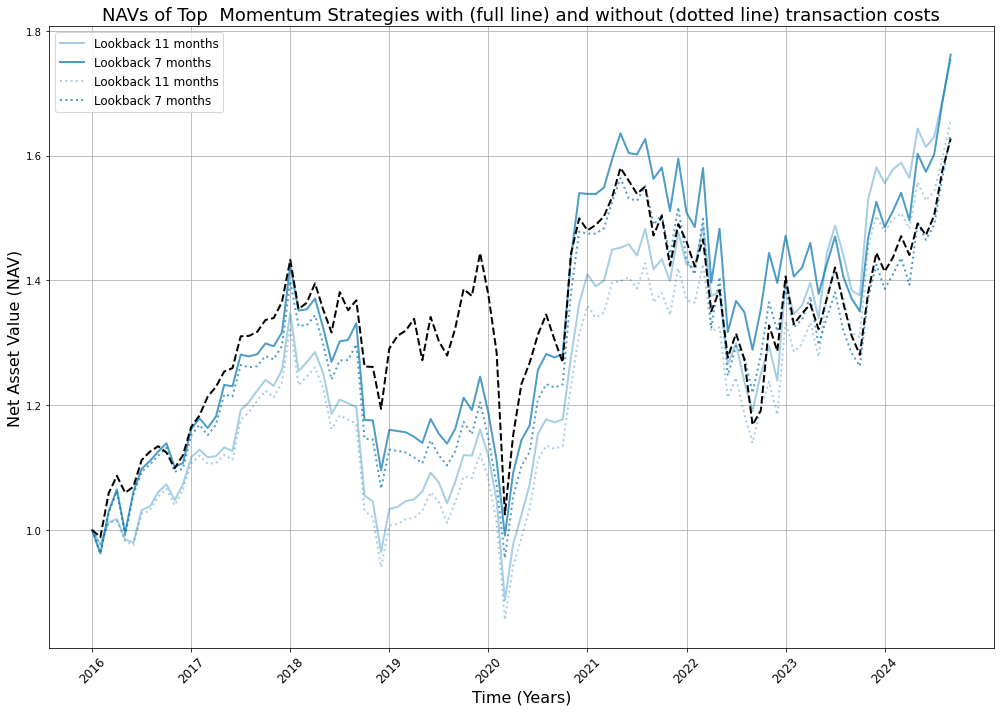

In [26]:
#plot1: top x lookbacks with and without trading costs

# To store legend entries for sorting
legend_entries = []

# Initialize the plot
plt.figure(figsize=(14, 10))

# Plot the NAVs for no TC 
for i, lookback_months in enumerate(top_x_lookbacks):
    alpha =  0.35 + 0.35 * i
    line1, = plt.plot(nav_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='-', linewidth=2, color=top_color, alpha=min(alpha, 1))  # Differentiated shades
    legend_entries.append((f'Lookback {lookback_months} months', line1))

# Plot the NAVs with TC 
for i, lookback_months in enumerate(top_x_lookbacks):
    alpha =  0.35 + 0.35 * i
    line1, = plt.plot(nav_wTC_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle=':', linewidth=2, color=top_color, alpha=min(alpha, 1))  # Differentiated shades
    legend_entries.append((f'Lookback {lookback_months} months', line1))

# Unpack sorted labels and line objects - because we sort the returns to only show best x lookbacks
sorted_labels, sorted_lines = zip(*legend_entries)

# Add the sorted legend right at the edge of the upper left corner
plt.legend(sorted_lines, sorted_labels, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)

# Add x-axis ticks and labels
x_data_points = range(len(monthlyDates4Fig))  
x_labels = [monthlyDates4Fig[i] for i in range(0, len(monthlyDates4Fig), 12)]  # Yearly intervals
plt.xticks(ticks=range(0, len(monthlyDates4Fig), 12), labels=x_labels, rotation=45, fontsize=12)

#add bechmark
plt.plot(benchmark_nav, label='Benchmark NAV', linestyle='--', linewidth=2, color='black')


# Additional plotting aesthetics
plt.title('NAVs of Top  Momentum Strategies with (full line) and without (dotted line) transaction costs', fontsize=18)
plt.xlabel('Time (Years)', fontsize=16)
plt.ylabel('Net Asset Value (NAV)', fontsize=16)
plt.grid(True)
plt.tight_layout()

# Save the figure to the correct directory - for use in latex report
output_directory = os.path.join(current_directory, 'reports', 'figures')
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, 'fig_costs.jpg')
plt.savefig(output_path, format='jpg', dpi=300)
plt.show()


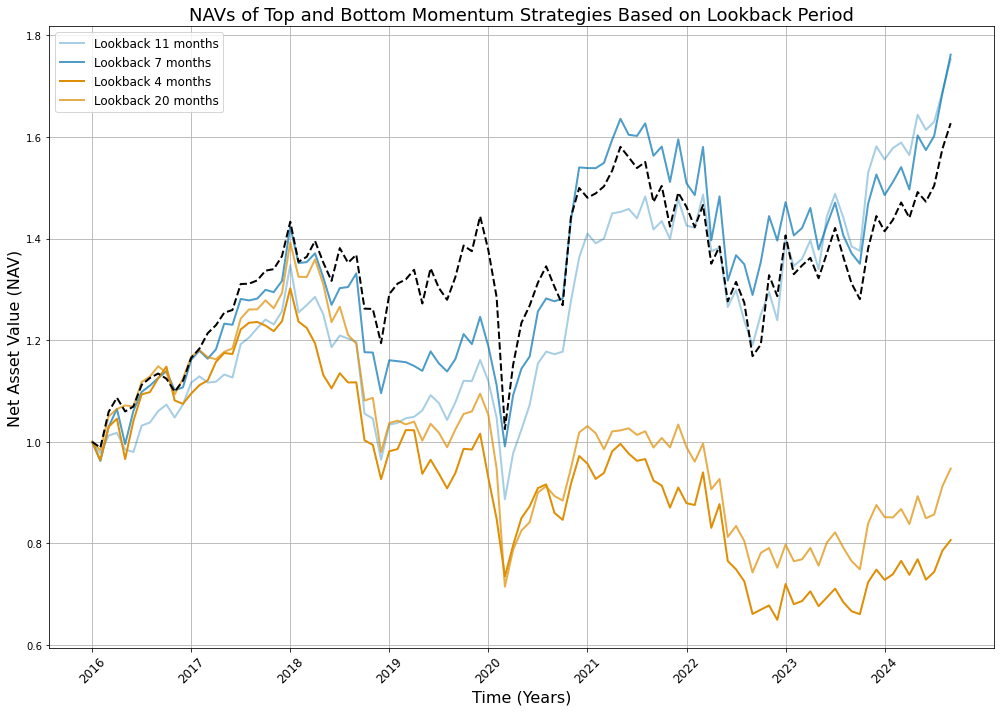

In [27]:
#Plot 2: Top versus bottom x lookbacks by performance

# To store legend entries for sorting
legend_entries = []

# Initialize the plot
plt.figure(figsize=(14, 10))

# Plot the NAVs for the top strategies
for i, lookback_months in enumerate(top_x_lookbacks):
    alpha =  0.35 + 0.35 * i #for differentaited shades
    line1, = plt.plot(nav_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='-', linewidth=2, color=top_color, alpha=min(alpha, 1))  # Adjust alpha
    legend_entries.append((f'Lookback {lookback_months} months', line1))

# Plot the NAVs for the bottom strategies 
for i, lookback_months in enumerate(bottom_x_lookbacks):
    alpha = 1 - 0.28 * i #for differentaited shades
    line1, = plt.plot(nav_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='-', linewidth=2, color=bottom_color, alpha=min(alpha, 1))  # Adjust alpha
    legend_entries.append((f'Lookback {lookback_months} months', line1))


# Unpack sorted labels and line objects - because we sort the returns to only show best x lookbacks and worst x lookbacks
sorted_labels, sorted_lines = zip(*legend_entries)

# Add the sorted legend right at the edge of the upper left corner
plt.legend(sorted_lines, sorted_labels, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)

# Add x-axis ticks and labels
x_data_points = range(len(monthlyDates4Fig))  # Example indices from MonthlyData4Fig
x_labels = [monthlyDates4Fig[i] for i in range(0, len(monthlyDates4Fig), 12)]  # Yearly intervals
plt.xticks(ticks=range(0, len(monthlyDates4Fig), 12), labels=x_labels, rotation=45, fontsize=12)

#add bechmark
plt.plot(benchmark_nav, label='Benchmark NAV', linestyle='--', linewidth=2, color='black')


# Additional plotting aesthetic
plt.title('NAVs of Top and Bottom Momentum Strategies Based on Lookback Period', fontsize=18)
plt.xlabel('Time (Years)', fontsize=16)
plt.ylabel('Net Asset Value (NAV)', fontsize=16)
plt.grid(True)
plt.tight_layout()
# Save the figure to the correct directory
output_directory = os.path.join(current_directory, 'reports', 'figures')
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, 'fig_bm.jpg')
plt.savefig(output_path, format='jpg', dpi=300)
plt.show()


## Performance statistics

Here we initiate the function containing different performance statistics and run it for all our lookback strategies and also for the benchmark.

In [28]:
def performance_stats(annualization_factor, strategy_xs_returns, rf):
    # Total strategy returns
    strategy_total_returns = strategy_xs_returns + rf

    # Final portfolio and risk-free values
    final_pf_value = np.prod(1 + strategy_total_returns)
    final_rf_value = np.prod(1 + rf)

    # Number of observations and years
    n_obs = len(rf)
    n_years = n_obs / annualization_factor

    # Average returns
    avg_total_return = (final_pf_value ** (1 / n_years) - 1)
    avg_rf = (final_rf_value ** (1 / n_years) - 1)
    avg_xs_return = avg_total_return - avg_rf

    # Standard deviation of excess returns
    std_xs_return = np.sqrt(annualization_factor) * np.std(strategy_xs_returns)

    # Sharpe Ratio
    sharpe_ratio = avg_xs_return / std_xs_return

    # Worst and best returns
    worst = np.min(strategy_xs_returns)
    best = np.max(strategy_xs_returns)

    # Skewness and kurtosis
    skewness = skew(strategy_xs_returns)
    kurt = kurtosis(strategy_xs_returns)

    # Return all results as a dictionary
    return {
        "avg_total_return": avg_total_return,
        "avg_rf": avg_rf,
        "avg_xs_return": avg_xs_return,
        "std_xs_return": std_xs_return,
        "sharpe_ratio": sharpe_ratio,
        "worst": worst,
        "best": best,
        "skewness": skewness,
        "kurtosis": kurt,

    }

In [29]:
df_Rf_Monthly_rep = pd.concat([df_Rf_Monthly] * max_lookback, axis=1) #replicate the Rf series so it has same dimention as strategy returns
df_Rf_Monthly_rep = df_Rf_Monthly_rep.apply(pd.to_numeric, errors='coerce')
df_strategy_returns_by_lookback = df_strategy_returns_by_lookback.apply(pd.to_numeric, errors='coerce')
df_Rf_Monthly_rep.columns = df_strategy_returns_by_lookback.columns
performance_stats_strategy = performance_stats(12,df_strategy_returns_by_lookback , df_Rf_Monthly_rep)
performance_stats_bm = performance_stats(12,df_benchmark_period_returns.iloc[:, 0].values , df_Rf_Monthly['Rf'].values)

C:\Users\jazbi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jazbi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [30]:
performance_stats_strategy

{'avg_total_return': 1     0.070437
 2     0.039424
 3     0.031155
 4    -0.004961
 5     0.051302
 6     0.077285
 7     0.091911
 8     0.064319
 9     0.054214
 10    0.077992
 11    0.088041
 12    0.076021
 13    0.070350
 14    0.080288
 15    0.067737
 16    0.073394
 17    0.049626
 18    0.034979
 19    0.033960
 20    0.013624
 21    0.034635
 22    0.081458
 23    0.061539
 24    0.048622
 dtype: float64,
 'avg_rf': 1     0.028459
 2     0.028459
 3     0.028459
 4     0.028459
 5     0.028459
 6     0.028459
 7     0.028459
 8     0.028459
 9     0.028459
 10    0.028459
 11    0.028459
 12    0.028459
 13    0.028459
 14    0.028459
 15    0.028459
 16    0.028459
 17    0.028459
 18    0.028459
 19    0.028459
 20    0.028459
 21    0.028459
 22    0.028459
 23    0.028459
 24    0.028459
 dtype: float64,
 'avg_xs_return': 1     0.041978
 2     0.010964
 3     0.002696
 4    -0.033420
 5     0.022843
 6     0.048826
 7     0.063451
 8     0.035860
 9     0.025755
 10    

In [31]:
performance_stats_bm

{'avg_total_return': 0.08156026094892121,
 'avg_rf': 0.028459247603402904,
 'avg_xs_return': 0.05310101334551831,
 'std_xs_return': 0.16132586774387078,
 'sharpe_ratio': 0.32915374383619744,
 'worst': -0.20187343526550316,
 'best': 0.13711538812884863,
 'skewness': -0.5120122163436696,
 'kurtosis': 3.1211001907952562}